## Final Project Submission

Please fill out:
* **Student name**: David Boyd
* **Student pace**: self paced 
* **Scheduled project review date/time**: N/A
* **Instructor name**: Abhineet Kulkarni


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import statsmodels.api as sm

%matplotlib inline

## Useful Functions

In [2]:
def diagnostic_plots(df, feature):
        '''
        Plots Histogram, Quartile Plot(Q-Q) and Boxplot 
        '''
        # define figure size
        plt.figure(figsize=(16, 4))

        # histogram
        plt.subplot(1, 3, 1)
        sns.histplot(df[feature], bins=25)
        plt.title('Histogram')

        # Q-Q plot
        plt.subplot(1, 3, 2)
        stats.probplot(df[feature], dist="norm", plot=plt)
        plt.ylabel('Feature quantiles')

        # boxplot
        plt.subplot(1, 3, 3)
        sns.boxplot(y=df[feature])
        plt.title('Boxplot')

        plt.show()

In [3]:
def adjust_skewness(df):
        """
        Function takes in a dataframe and returns a dataframe which isn't impacted by skewness anymore
        """
        ## Getting all the data that are not of "object" type. 
        numeric = df.dtypes[df.dtypes != "object"].index

        # Check the skew of all numerical features
        skewed_feats = df[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
        high_skew = skewed_feats[abs(skewed_feats) > 0.5]
        skewed_features = high_skew.index
        
        for feat in skewed_features:
            df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

## EDA Phase

In [4]:
df = pd.read_csv('data/kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  int64  
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
df.head()

id        date   price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7129300520  10/13/2014  221900         3       1.00         1180      5650   
1  6414100192   12/9/2014  538000         3       2.25         2570      7242   
2  5631500400   2/25/2015  180000         2       1.00          770     10000   
3  2487200875   12/9/2014  604000         4       3.00         1960      5000   
4  1954400510   2/18/2015  510000         3       2.00         1680      8080   

   floors waterfront  view  ...          grade sqft_above  sqft_basement  \
0     1.0        NaN  NONE  ...      7 Average       1180              0   
1     2.0         NO  NONE  ...      7 Average       2170            400   
2     1.0         NO  NONE  ...  6 Low Average        770              0   
3     1.0         NO  NONE  ...      7 Average       1050            910   
4     1.0         NO  NONE  ...         8 Good       1680              0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

In [6]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
"""Looking at the above, we can see there are null values in yr_renovated, view, waterfront which need to be 
handled before potentially using them in a model. It is also clear that certain fields won't be useful to the model,
these are lat, long, date and id"""

"Looking at the above, we can see there are null values in yr_renovated, view, waterfront which need to be \nhandled before potentially using them in a model. It is also clear that certain fields won't be useful to the model,\nthese are lat, long, date and id"

In [8]:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    sqft_above      yr_built  yr_renovated  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  17755.000000   
mean   1.509941e+04      1.494096   1788.596842   1970.999676     83.636778   
std    4.141264e+04      0.539683    827.759761     29.375234    399.946414   
min    5.200000e+02      1.000000    370.000000   1900.000000      0.000000   
25%    5.040000e+03      1.000000   1190.000000   1951.000000      0.000000   
50%    7.618000e+03      1.500000   1560.000000   1975.000000      0.000000   
75%    1.068500e+04      2.000000   2210.000000   1997.000000      0.000000   
max    1.651359e+06      3.500000   9410.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000  21597.000000   21597.000000   21597.000000  
mean   98077.951845     47.560093   -122.213982    1986.620318   12758.283512  
std       53.513072      0.138552      0.140724     685.230472   27274.441950  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471100   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.231000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

Looking at the describe function above, we can see some clear outliers across several features, which will need handling before building an effective model

In [9]:
df_cat = df[['waterfront', 'view', 'condition', 'grade', 'yr_renovated', 'sqft_basement']]
df_cat.head()

waterfront  view  condition          grade  yr_renovated sqft_basement
0        NaN  NONE    Average      7 Average           0.0             0
1         NO  NONE    Average      7 Average        1991.0           400
2         NO  NONE    Average  6 Low Average           NaN             0
3         NO  NONE  Very Good      7 Average           0.0           910
4         NO  NONE    Average         8 Good           0.0             0

In [10]:
for col in df_cat.columns:
    print(df_cat[col].unique()) # to print categories name only
    print(df_cat[col].value_counts()) # to print count of every category

[nan 'NO' 'YES']
NO     19075
YES      146
Name: waterfront, dtype: int64
['NONE' nan 'GOOD' 'EXCELLENT' 'AVERAGE' 'FAIR']
NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64
['Average' 'Very Good' 'Good' 'Poor' 'Fair']
Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64
['7 Average' '6 Low Average' '8 Good' '11 Excellent' '9 Better' '5 Fair'
 '10 Very Good' '12 Luxury' '4 Low' '3 Poor' '13 Mansion']
7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64
[   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987

## Preprocessing Stage

Looking at the above tables there are several steps to complete in this section, which have been listed below:
- Clean up the missing values on the yr_renovated column, assume is NAN then it hasn't been renovated, so 0 will be inputted.
- Using the date, pull out the yr_sold to help calculate the age of the property at sale, years since renovation
- Calculate sqft_outdoors from sqft_lot - sqft_living to see if an increase in outdoor space influences price
- Create booleans to identify if it has had a renovation, or if the property has a basement, to show roughly what extra value they add to a property (considered with the age/size of each feature later on)

Once the steps above have been completed we are able to look at the correlation between different features with the price. This will help us determine which features we are able to drop, then can begin on encoding any categorical columns left.

In [11]:
df['date'] = pd.to_datetime(df['date'])
df['yr_sold'] = df['date'].dt.year
df['prop_age'] = abs(df['yr_sold'] - df['yr_built'])

df['yr_renovated'].fillna(0, inplace=True)

In [12]:
df['yrs_since_upgrade'] = np.where(df['yr_renovated'] == 0, df['prop_age'],
                          np.where(df['yr_renovated'] != 0, abs(df['yr_sold'] - df['yr_renovated']), 0))

df['had_upgrade'] = np.where(df['yr_renovated'] == 0, "No",
                          np.where(df['yr_renovated'] != 0, "Yes", "No"))

df['has_basement'] = np.where(df['sqft_basement'].isin([0,'?']) , "No",
                          np.where(df['sqft_basement'] != 0, "Yes", "No"))

df['sqft_basement'] = df['sqft_living'] - df['sqft_above']


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 21597 non-null  int64         
 1   date               21597 non-null  datetime64[ns]
 2   price              21597 non-null  int64         
 3   bedrooms           21597 non-null  int64         
 4   bathrooms          21597 non-null  float64       
 5   sqft_living        21597 non-null  int64         
 6   sqft_lot           21597 non-null  int64         
 7   floors             21597 non-null  float64       
 8   waterfront         19221 non-null  object        
 9   view               21534 non-null  object        
 10  condition          21597 non-null  object        
 11  grade              21597 non-null  object        
 12  sqft_above         21597 non-null  int64         
 13  sqft_basement      21597 non-null  int64         
 14  yr_bui

In [14]:
# Dropping all unneccesary columns
df = df.drop(['id','date', 'waterfront', 'view', 'zipcode', 'lat', 'long', 'yr_renovated', 'sqft_living', 'sqft_lot', 'yr_built', 'yr_sold'], axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              21597 non-null  int64  
 1   bedrooms           21597 non-null  int64  
 2   bathrooms          21597 non-null  float64
 3   floors             21597 non-null  float64
 4   condition          21597 non-null  object 
 5   grade              21597 non-null  object 
 6   sqft_above         21597 non-null  int64  
 7   sqft_basement      21597 non-null  int64  
 8   sqft_living15      21597 non-null  int64  
 9   sqft_lot15         21597 non-null  int64  
 10  prop_age           21597 non-null  int64  
 11  yrs_since_upgrade  21597 non-null  float64
 12  had_upgrade        21597 non-null  object 
 13  has_basement       21597 non-null  object 
dtypes: float64(3), int64(7), object(4)
memory usage: 2.3+ MB


In [16]:
cond_dict = {'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5}

df.replace({"condition": cond_dict}, inplace=True)
df['condition'] = df['condition'].astype(int)

In [17]:
grade_dict = {'3 Poor':3, 
              '4 Low':4, 
              '5 Fair':5, 
              '6 Low Average':6,
              '7 Average':7,
              '8 Good':8,
              '9 Better':9,
              '10 Very Good':10,
              '11 Excellent':11,
              '12 Luxury':12,
              '13 Mansion':13}

df.replace({"grade": grade_dict}, inplace=True)
df['grade'] = df['grade'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              21597 non-null  int64  
 1   bedrooms           21597 non-null  int64  
 2   bathrooms          21597 non-null  float64
 3   floors             21597 non-null  float64
 4   condition          21597 non-null  int64  
 5   grade              21597 non-null  int64  
 6   sqft_above         21597 non-null  int64  
 7   sqft_basement      21597 non-null  int64  
 8   sqft_living15      21597 non-null  int64  
 9   sqft_lot15         21597 non-null  int64  
 10  prop_age           21597 non-null  int64  
 11  yrs_since_upgrade  21597 non-null  float64
 12  had_upgrade        21597 non-null  object 
 13  has_basement       21597 non-null  object 
dtypes: float64(3), int64(9), object(2)
memory usage: 2.3+ MB


Time to visualise each of the numeric columns left to understand whether they are normally distributed or not.

<AxesSubplot:>

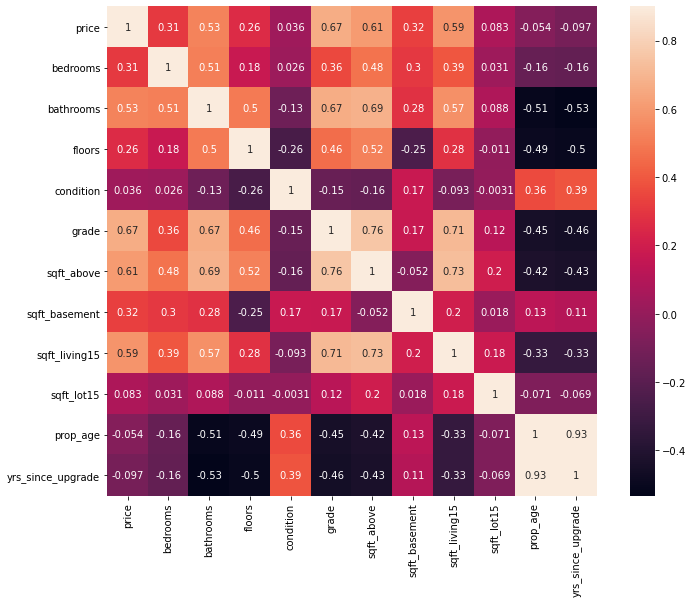

In [18]:
# Plot the Correlation map to see how features are correlated with target: Price
corr_matrix = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True, annot=True)

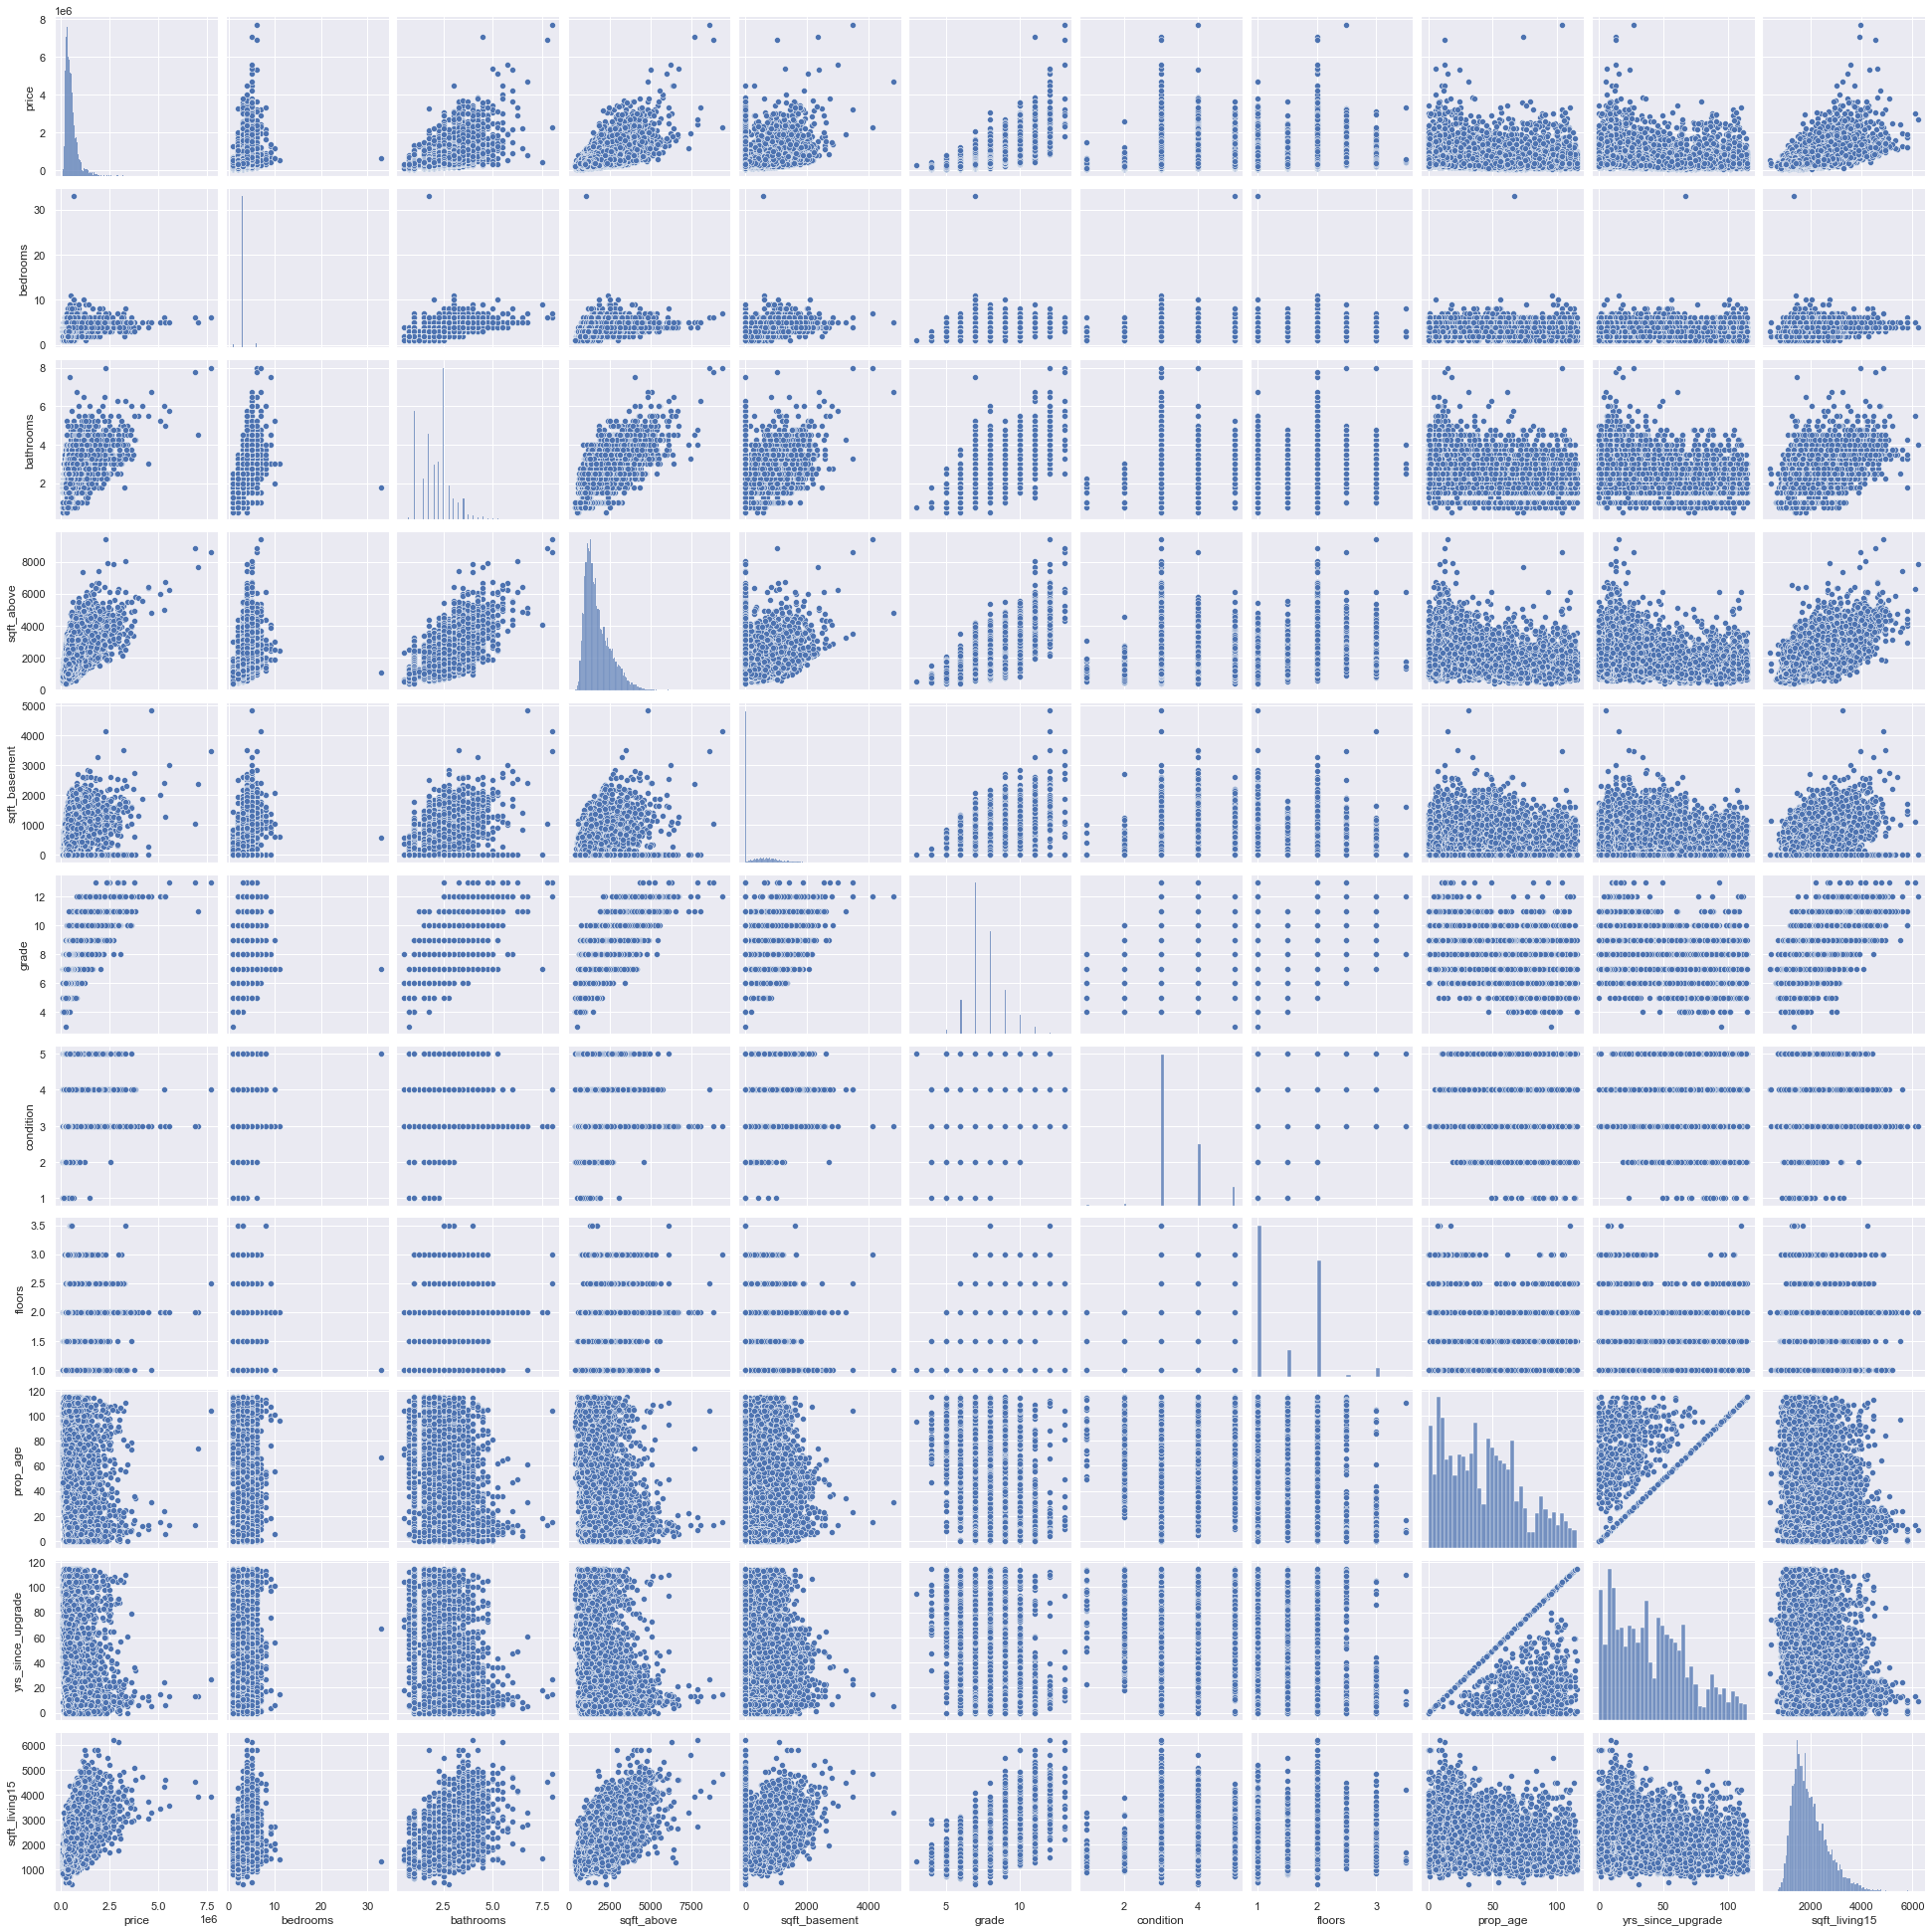

In [19]:
sns.set()
cols = ['price', 'bedrooms', 'bathrooms','sqft_above', 'sqft_basement' ,'grade','condition',
        'floors', 'prop_age', 'yrs_since_upgrade', 'sqft_living15']
sns.pairplot(df[cols], height = 2.5)
plt.show();

## Handling Outliers

After handling the outliers, we need to handle the following aspects:
- Numeric data needs to be standardised
- Categorical data needs to be one hot encoded/binary encoded
- Transform the price to remove skewness

In [20]:
df_numeric = df.select_dtypes(exclude = 'object')

z_score = np.abs(stats.zscore(df_numeric))
no_outliers = (z_score < 3).all(axis = 1)
df_filtered = df_numeric[no_outliers]
df_filtered.head()

price  bedrooms  bathrooms  floors  condition  grade  sqft_above  \
0  221900         3       1.00     1.0          3      7        1180   
1  538000         3       2.25     2.0          3      7        2170   
2  180000         2       1.00     1.0          3      6         770   
3  604000         4       3.00     1.0          5      7        1050   
4  510000         3       2.00     1.0          3      8        1680   

   sqft_basement  sqft_living15  sqft_lot15  prop_age  yrs_since_upgrade  
0              0           1340        5650        59               59.0  
1            400           1690        7639        63               23.0  
2              0           2720        8062        82               82.0  
3            910           1360        5000        49               49.0  
4              0           1800        7503        28               28.0

In [21]:
adjust_skewness(df_filtered)

/Users/davidboyd/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
<ipython-input-3-6fd56b8acd45>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))


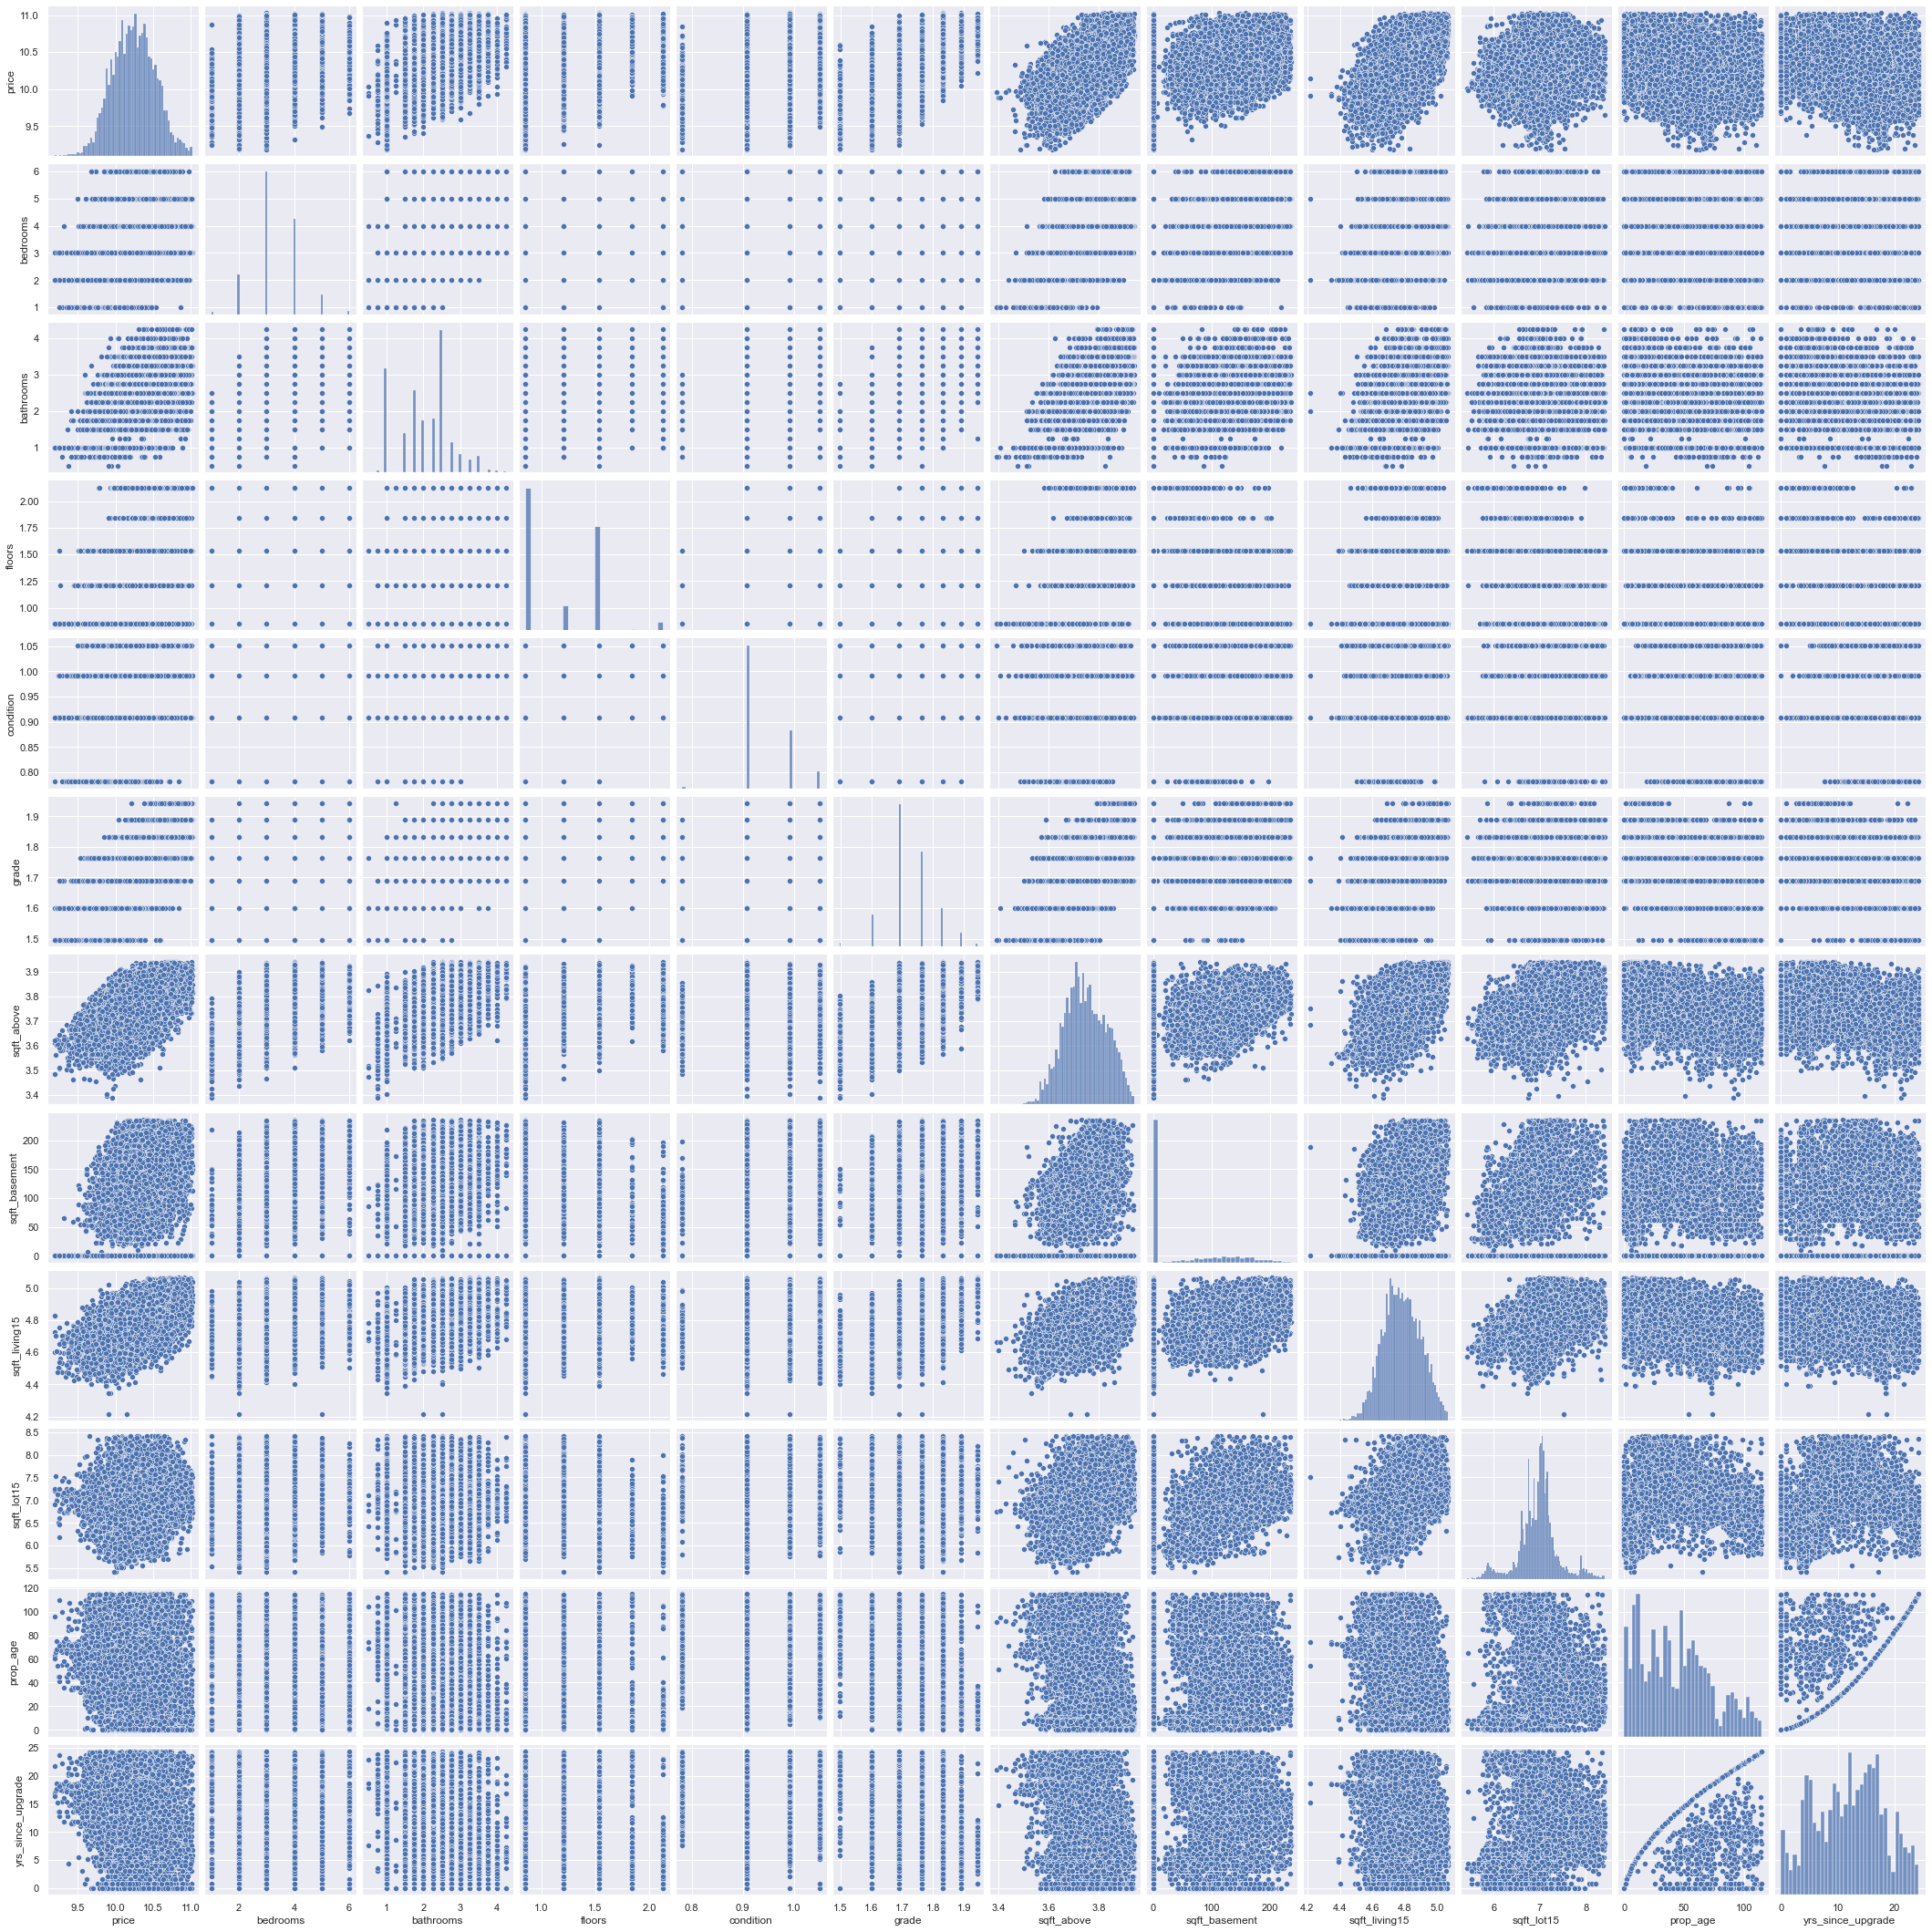

In [22]:
sns.pairplot(df_filtered)

<AxesSubplot:>

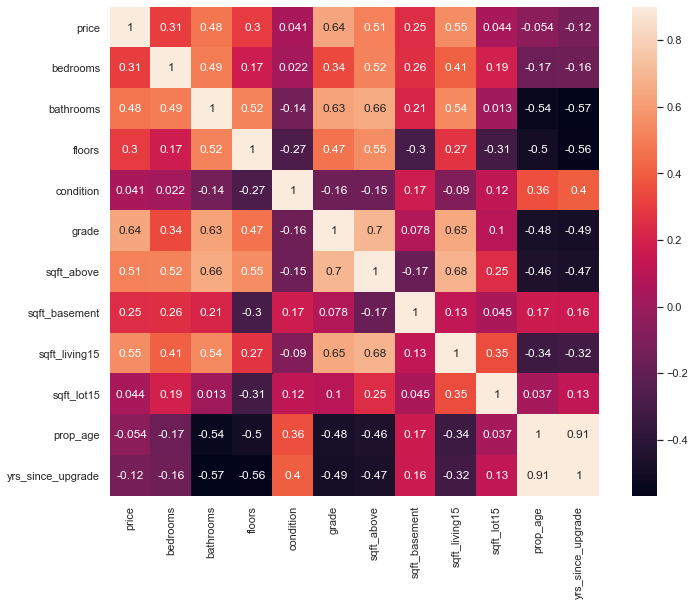

In [23]:
corr_matrix = df_filtered.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True, annot=True)

In [24]:
X = df_filtered.drop('price', axis=1)
y = df_filtered['price']

In [25]:
X.info()

df_numeric_cols = X.columns
# Instantiate a standard scaler object
ss = StandardScaler()

# Fit and transform our numeric data to the ss object
df_numeric = pd.DataFrame(ss.fit_transform(X))
df_numeric.set_index(X.index, inplace = True)

df_numeric.columns = df_numeric_cols
df_numeric.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20296 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           20296 non-null  int64  
 1   bathrooms          20296 non-null  float64
 2   floors             20296 non-null  float64
 3   condition          20296 non-null  float64
 4   grade              20296 non-null  float64
 5   sqft_above         20296 non-null  float64
 6   sqft_basement      20296 non-null  float64
 7   sqft_living15      20296 non-null  float64
 8   sqft_lot15         20296 non-null  float64
 9   prop_age           20296 non-null  int64  
 10  yrs_since_upgrade  20296 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 1.9 MB


bedrooms  bathrooms    floors  condition     grade  sqft_above  \
0 -0.383056  -1.515816 -0.910213  -0.643434 -0.494267   -0.703764   
1 -0.383056   0.283644  0.987390  -0.643434 -0.494267    0.822053   
2 -1.555680  -1.515816 -0.910213  -0.643434 -1.641238   -1.894581   
3  0.789569   1.363320 -0.910213   2.201813 -0.494267   -1.018922   
4 -0.383056  -0.076248 -0.910213  -0.643434  0.491421    0.204620   

   sqft_basement  sqft_living15  sqft_lot15  prop_age  yrs_since_upgrade  
0      -0.720652      -1.019518   -0.331009  0.517412           0.677246  
1       0.588354      -0.245228    0.103870  0.653612          -0.526360  
2      -0.720652       1.271311    0.180799  1.300564           1.277002  
3       1.602738      -0.969384   -0.509354  0.176911           0.385592  
4      -0.720652      -0.038837    0.078176 -0.538141          -0.326180

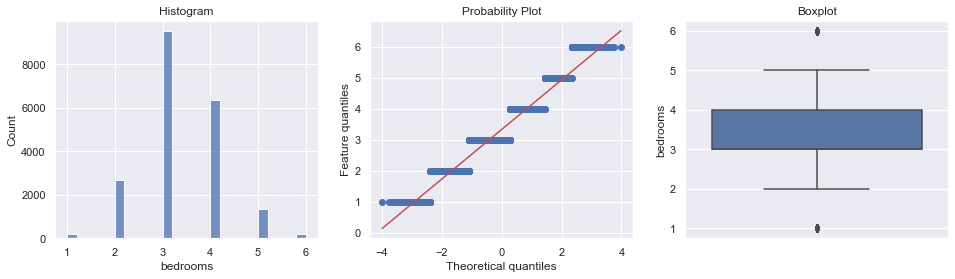

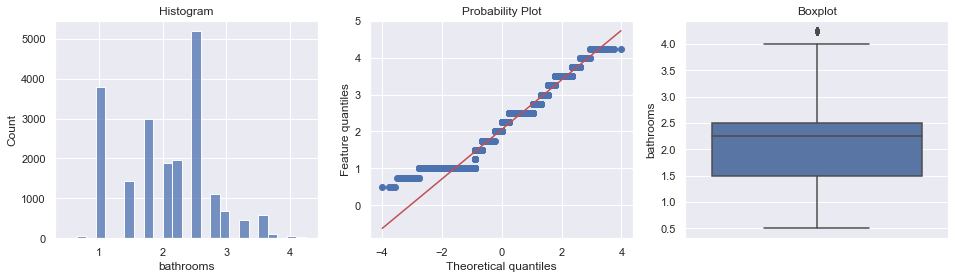

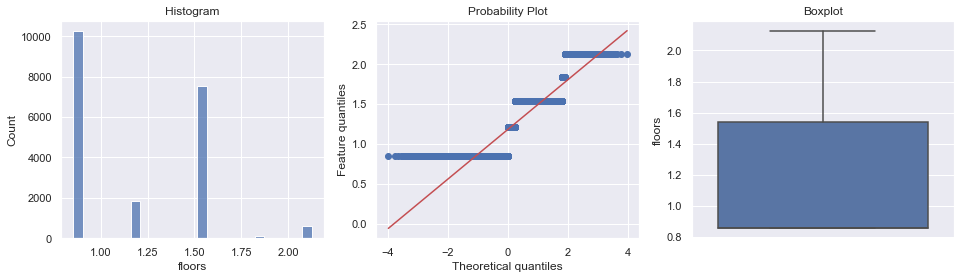

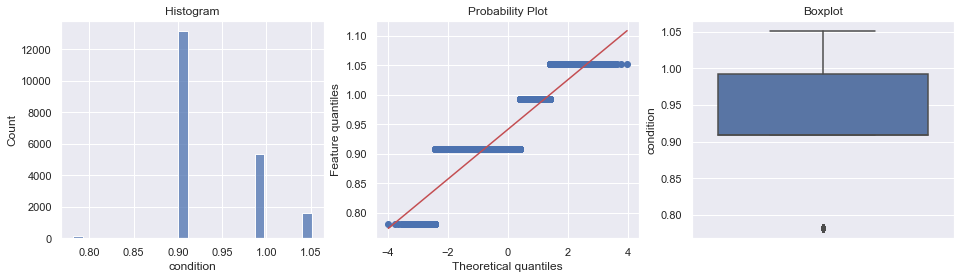

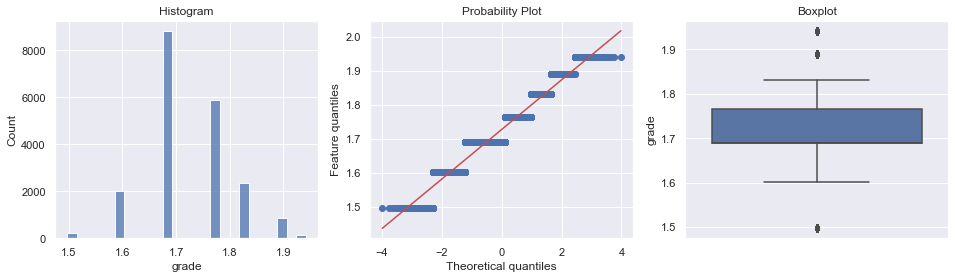

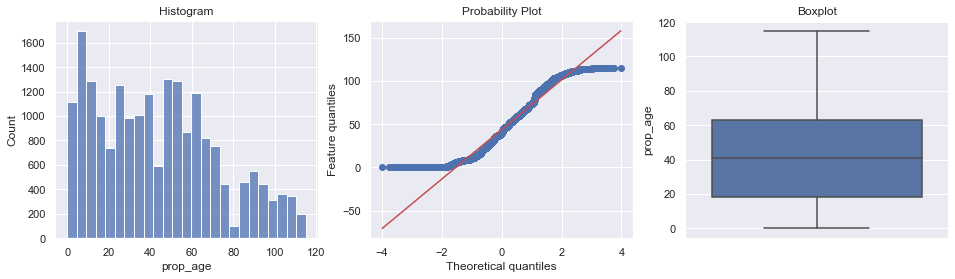

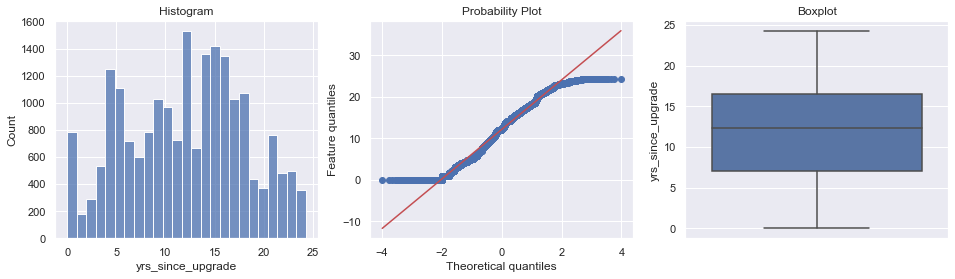

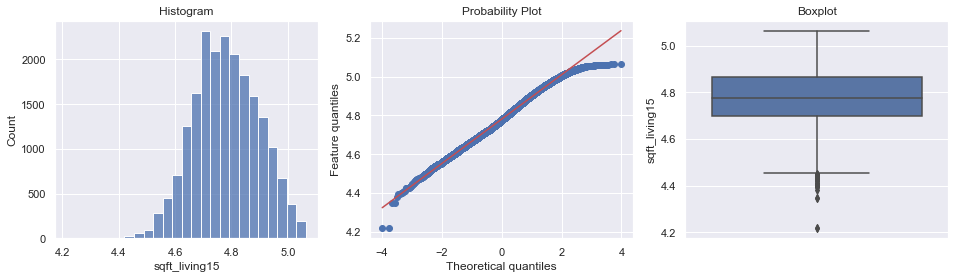

In [58]:
var = ['bedrooms', 'bathrooms', 'sqft_above', 'sqft_basement', 'floors',
       'condition', 'grade', 'prop_age', 'yrs_since_upgrade', 'sqft_living15']

for x in var:
    diagnostic_plots(X,x)

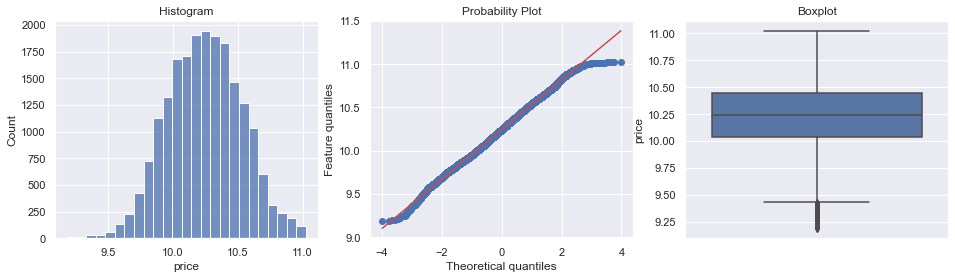

In [34]:
plt.figure(figsize=(16, 4))

        # histogram
plt.subplot(1, 3, 1)
sns.histplot(y, bins=25)
plt.title('Histogram')

        # Q-Q plot
plt.subplot(1, 3, 2)
stats.probplot(y, dist="norm", plot=plt)
plt.ylabel('Feature quantiles')

        # boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=y)
plt.title('Boxplot')

plt.show()

In [35]:
df_cat = df.loc[X.index]
df_cat = df_cat.select_dtypes(include = 'object')
df_cat.head()

from sklearn.preprocessing import LabelBinarizer

# Create a binarizer object for each binary categorical variable
upgrade_bin = LabelBinarizer()
basement_bin = LabelBinarizer()

# Fit and transform each respective binary cat variable to their respective binarizer objects
df_cat['had_upgrade'] = upgrade_bin.fit_transform(df_cat['had_upgrade'])
df_cat['has_basement'] = basement_bin.fit_transform(df_cat['has_basement'])

df_cat.head()

had_upgrade  has_basement
0            0             1
1            1             1
2            0             1
3            0             1
4            0             1

In [37]:
# Merge numerical data and categorical data
X_prep = pd.merge(df_cat, X, left_index = True, right_index = True)
X_prep.head()

had_upgrade  has_basement  bedrooms  bathrooms    floors  condition  \
0            0             1         3       1.00  0.853018   0.908772   
1            1             1         3       2.25  1.535993   0.908772   
2            0             1         2       1.00  0.853018   0.908772   
3            0             1         4       3.00  0.853018   1.051467   
4            0             1         3       2.00  0.853018   0.908772   

      grade  sqft_above  sqft_basement  sqft_living15  sqft_lot15  prop_age  \
0  1.689392    3.686960       0.000000       4.663428    6.828133        59   
1  1.689392    3.816627      89.485331       4.752436    7.011192        63   
2  1.601396    3.585761       0.000000       4.926768    7.043575        82   
3  1.689392    3.660177     158.829935       4.669191    6.753060        49   
4  1.765015    3.764156       0.000000       4.776161    7.000376        28   

   yrs_since_upgrade  
0          16.175432  
1           8.912925  
2          19.794331  
3          14.415603  
4          10.120801

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_prep['sqft_above'], y, test_size=0.2, random_state=51)

In [48]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train.values.reshape(-1,1), y_train)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test.values.reshape(-1,1))
y_train_pred = regr.predict(X_train.values.reshape(-1,1))

In [49]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.061, test: 0.059
R^2 train: 0.265, test: 0.249


In [53]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_prep, y, test_size=0.2, random_state=51)

In [61]:
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train1, y_train1)

# Make predictions using the testing set
y_test_pred = regr.predict(X_test1)
y_train_pred = regr.predict(X_train1)

In [51]:
# Create model intercept
predictors_int1 = sm.add_constant(X_train)

# Fit model to data
model1 = sm.OLS(y_train,predictors_int1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     5848.
Date:                Tue, 08 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:55:03   Log-Likelihood:                -352.54
No. Observations:               16236   AIC:                             709.1
Df Residuals:                   16234   BIC:                             724.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7010      0.086     43.254      0.000       3.533       3.869
sqft_above     1.7460      0.023     76.474      0.000       1.701       1.791
==============================================================================
Omnibus:                      236.636   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.295
Skew:                          -0.035   Prob(JB):                     3.43e-31
Kurtosis:                       2.550   Cond. No.                         177.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

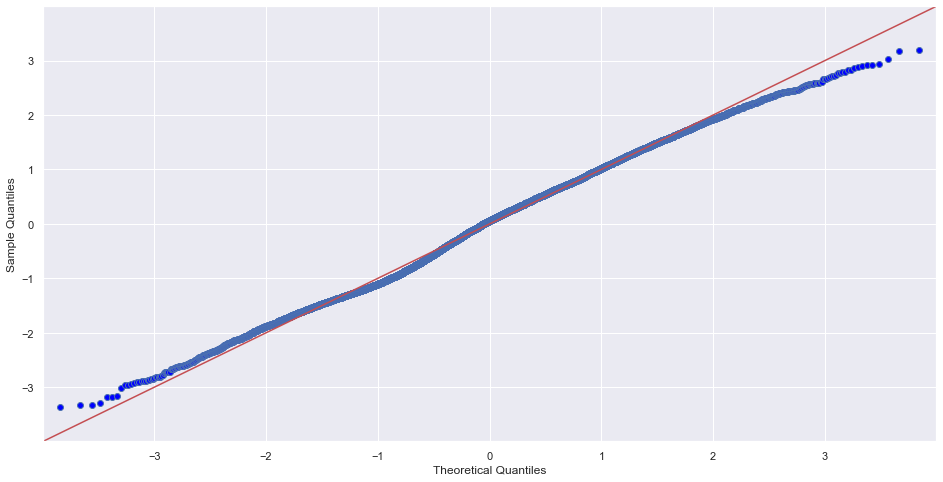

In [59]:
fig, ax = plt.subplots(figsize = (16,8))

res = model1.resid # residuals

sm.qqplot(res, fit=True, line='45', ax=ax);

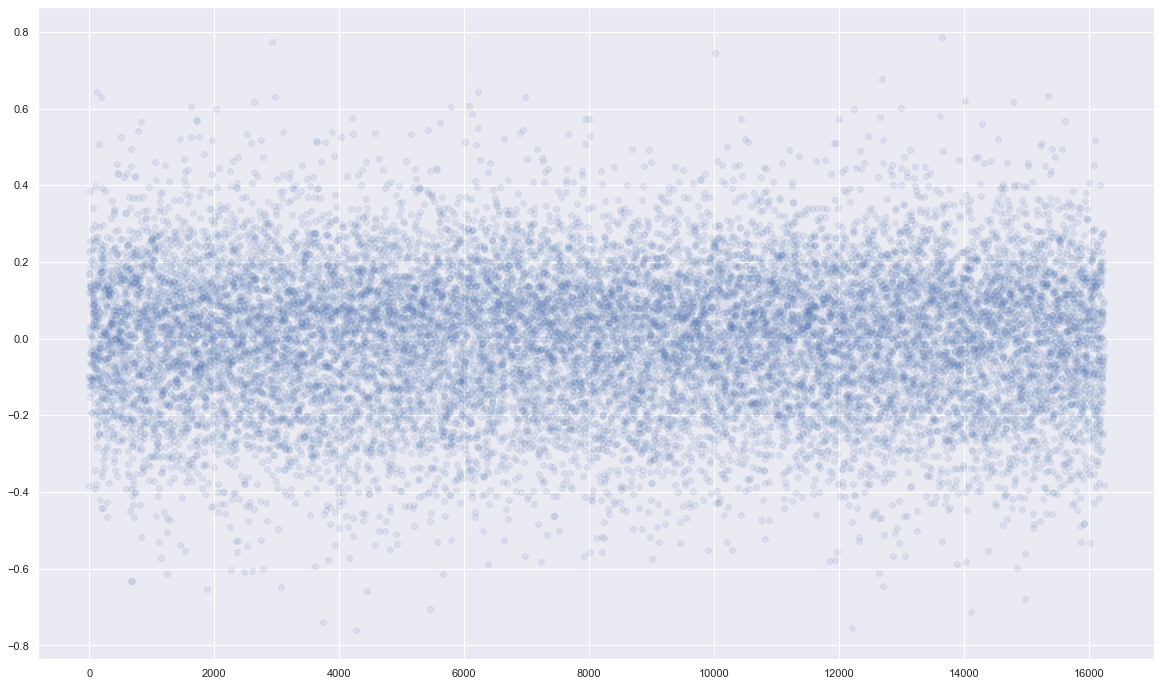

In [63]:
fig, ax = plt.subplots(figsize = (20,12))

resid = (y_train1 - y_train_pred)
plt.scatter(x=range(y_train_pred.shape[0]), y=resid, alpha=0.1)

In [54]:
# Create model intercept
predictors_int2 = sm.add_constant(X_train1)

# Fit model to data
model2 = sm.OLS(y_train1,predictors_int2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     1818.
Date:                Tue, 08 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:01:15   Log-Likelihood:                 4448.4
No. Observations:               16236   AIC:                            -8869.
Df Residuals:                   16222   BIC:                            -8761.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9819      0.108     18.310      0.000       1.770       2.194
had_upgrade          -0.0831      0.015     -5.400      0.000      -0.113      -0.053
has_basement        8.22e-05      0.010      0.008      0.994      -0.020       0.020
bedrooms             -0.0219      0.002     -9.771      0.000      -0.026      -0.018
bathrooms             0.0353      0.004      9.438      0.000       0.028       0.043
floors                0.0601      0.007      9.225      0.000       0.047       0.073
condition             0.3905      0.032     12.195      0.000       0.328       0.453
grade                 1.7222      0.031     56.396      0.000       1.662       1.782
sqft_above            0.6988      0.038     18.583      0.000       0.625       0.773
sqft_basement         0.0008   2.98e-05     25.308      0.000       0.001       0.001
sqft_living15         0.5396      0.020     27.129      0.000       0.501       0.579
sqft_lot15           -0.0723      0.005    -15.708      0.000      -0.081      -0.063
prop_age              0.0052      0.000     23.891      0.000       0.005       0.006
yrs_since_upgrade    -0.0089      0.001     -8.004      0.000      -0.011      -0.007
==============================================================================
Omnibus:                       73.015   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.206
Skew:                          -0.135   Prob(JB):                     1.04e-17
Kurtosis:                       3.207   Cond. No.                     7.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_prep[['grade', 'sqft_above', 'bathrooms', 'bedrooms']], y, test_size=0.2, random_state=51)

In [57]:
# Create model intercept
predictors_int3 = sm.add_constant(X_train2)

# Fit model to data
model3 = sm.OLS(y_train2,predictors_int3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     2970.
Date:                Tue, 08 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:03:43   Log-Likelihood:                 1609.1
No. Observations:               16236   AIC:                            -3208.
Df Residuals:                   16231   BIC:                            -3170.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8415      0.100     58.399      0.000       5.645       6.038
grade          1.9519      0.033     58.944      0.000       1.887       2.017
sqft_above     0.2405      0.033      7.396      0.000       0.177       0.304
bathrooms      0.0328      0.004      9.113      0.000       0.026       0.040
bedrooms       0.0189      0.002      7.670      0.000       0.014       0.024
==============================================================================
Omnibus:                       42.113   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.505
Skew:                           0.038   Prob(JB):                     3.22e-08
Kurtosis:                       2.787   Cond. No.                         352.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""